# Summarise audience motion per section of concert
Plot and describe how the audience moved to the music as it was performed. More or less, shifting together or not

Look at how pairs of participants share movemement, in hall

First load audience motion data (summary QoM), proximity info, concert timing info and then calculate correlations per pair and condition. 

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d
import pingouin as pg

In [2]:
# import activity analysis functions from aa.py file in the same folder as this jupiter notebook
%load_ext autoreload
%autoreload 1
%aimport aa

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [23]:
%reload_ext autoreload

In [44]:
BPM = 108

BPM/60



1.8

In [3]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns)
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 

    data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

In [4]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (fs/2)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [5]:
general_loc = 'C:/Users/finnu/OneDrive - Universitetet i Oslo/Documents/Mobile_data/'

public_mlmotion = general_loc + 'Public/Motion_ML/'
public_ax3 = general_loc +  'Public/Motion_AX3/'
public_Part = general_loc + 'Public/Participants/'
public_time = general_loc + 'Public/Timing/'

In [7]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [8]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [11]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)
#concert_times.iloc[50:75]

In [10]:
Main_concert_times

Time_s  Time_ms                   Event  \
Datetime                                                        
2021-10-26 17:36:35  -691.24  -691240         Clapping for MC   
2021-10-26 17:36:53  -673.12  -673120                  Speech   
2021-10-26 17:38:50  -556.04  -556040         Clapping for MC   
2021-10-26 17:38:56  -550.16  -550160                  Speech   
2021-10-26 17:45:16  -169.64  -169640         Clapping for MC   
2021-10-26 17:47:02   -63.68   -63680                  Speech   
2021-10-26 17:48:06     0.00        0                  Taps 1   
2021-10-26 17:48:20    14.38    14380  Clapping for Musicians   
2021-10-26 17:49:03    57.40    57400             Beethoven 1   
2021-10-26 17:56:02   476.08   476080             Beethoven 2   
2021-10-26 17:59:47   701.18   701180             Beethoven 3   
2021-10-26 18:07:36  1170.16  1170160             Beethoven 4   
2021-10-26 18:14:56  1610.36  1610360  Clapping for Beethoven   
2021-10-26 18:15:28  1642.00  1642000                  Speech   
2021-10-26 18:15:48  1662.00  1662000    Survey for Beethoven   
2021-10-26 18:21:19  1992.94  1992940                  Speech   
2021-10-26 18:21:30  2004.44  2004440  Clapping for Musicians   
2021-10-26 18:22:20  2054.48  2054480             Schnittke 1   
2021-10-26 18:28:25  2418.76  2418760             Schnittke 2   
2021-10-26 18:34:01  2755.28  2755280             Schnittke 3   
2021-10-26 18:42:48  3282.36  3282360  Clapping for Schnittke   
2021-10-26 18:43:51  3344.76  3344760                  Speech   
2021-10-26 18:44:48  3402.20  3402200    Survey for Schnittke   
2021-10-26 19:09:27  4880.92  4880920                  Speech   
2021-10-26 19:11:28  5002.36  5002360         Clapping for MC   
2021-10-26 19:11:46  5019.80  5019800                  Speech   
2021-10-26 19:14:34  5188.28  5188280                  Taps 2   
2021-10-26 19:14:53  5206.92  5206920  Clapping for Musicians   
2021-10-26 19:16:00  5274.36  5274360                    Bach   
2021-10-26 19:28:25  6019.44  6019440       Clapping for Bach   
2021-10-26 19:28:47  6041.08  6041080                  Speech   
2021-10-26 19:29:07  6061.34  6061340         Survey for Bach   
2021-10-26 19:31:39  6213.28  6213280                  Speech   
2021-10-26 19:32:37  6271.28  6271280                  Folk 1   
2021-10-26 19:40:45  6758.96  6758960     Clapping for Folk 1   
2021-10-26 19:41:02  6776.48  6776480                  Folk 2   
2021-10-26 19:43:39  6933.24  6933240     Clapping for Folk 2   
2021-10-26 19:43:59  6952.84  6952840                  Speech   
2021-10-26 19:44:17  6970.80  6970800                  Folk 3   
2021-10-26 19:47:36  7170.12  7170120     Clapping for Folk 3   
2021-10-26 19:47:56  7189.96  7189960                  Speech   
2021-10-26 19:48:29  7222.76  7222760                  Folk 4   
2021-10-26 19:53:43  7537.22  7537220     Clapping for Folk 4   
2021-10-26 19:54:00  7553.78  7553780                  Speech   
2021-10-26 19:54:13  7566.90  7566900                  Folk 5   
2021-10-26 19:57:14  7748.24  7748240     Clapping for Folk 5   
2021-10-26 19:57:29  7762.80  7762800                  Speech   
2021-10-26 19:57:38  7771.88  7771880         Clapping for MC   
2021-10-26 19:57:41  7775.36  7775360                  Speech   
2021-10-26 19:58:21  7815.12  7815120                  Speech   
2021-10-26 19:58:51  7845.10  7845100                  Folk 6   
2021-10-26 20:02:08  8042.24  8042240          Clapping Final   
2021-10-26 20:03:58  8152.06  8152060         Survey for Folk   
2021-10-26 20:16:49  8922.88  8922880          Return sensors   

                          Event_Type  Time_Stream  Event_Duration  sequence  
Datetime                                                                     
2021-10-26 17:36:35         Applause       946.00           18.12         0  
2021-10-26 17:36:53           Speech       964.12          117.08         1  
2021-10-26 17:38:50         Applause      1081.20            5.88    

In [31]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'] == 'A',:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
alignedParts

Participant_Code  Participant_Number Attendance Questionnaire_Language  \
0            ADQ001                   1          A                      D   
1            ADQ002                   2          A                      D   
2            ADQ003                   3          A                      D   
3            ADQ004                   4          A                      D   
4            ADQ005                   5          A                      D   
..              ...                 ...        ...                    ...   
80           AEQ086                  86          A                      E   
81           AEQ087                  87          A                      E   
82           AEQ088                  88          A                      E   
83           AEQ089                  89          A                      E   
84           AER090                  90          A                      E   

   Motion_Quality  Link_Conflicts  Seat_Zone Location  Longitude_Truncated  \
0               Q               0        6.0      NaN                  NaN   
1               Q               0        3.0      NaN                  NaN   
2               Q               0        2.0      NaN                  NaN   
3               Q               0        4.0      NaN                  NaN   
4               Q               0        4.0      NaN                  NaN   
..            ...             ...        ...      ...                  ...   
80              Q               0        5.0      NaN                  NaN   
81              Q               1        3.0      NaN                  NaN   
82              Q               0        2.0      NaN                  NaN   
83              Q               0        4.0      NaN                  NaN   
84              R               1        3.0      NaN                  NaN   

    Lattitude_Truncated  Offset_1  Offset_2  Watch_Alone  
0                   NaN      0.14      0.16          0.0  
1                   NaN       NaN     -0.36          0.0  
2                   NaN      0.88      1.02          0.0  
3                   NaN      0.44      0.62          1.0  
4                   NaN      0.04      0.12          0.0  
..                  ...       ...       ...          ...  
80                  NaN       NaN      0.34          0.0  
81                  NaN      0.12      0.28          0.0  
82                  NaN      0.10      0.06          0.0  
83                  NaN      0.28      0.38          0.0  
84                  NaN      0.94      1.06          0.0  

[85 rows x 13 columns]

In [1]:
Main_concert_times#[Main_concert_times['Event'].str.contains('Beethoven')]

NameError: name 'Main_concert_times' is not defined

In [33]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b*6 
    else:
        aud_df[part] = b
#     if np.nanmedian(b)>0:
#         aud_df[part] = b/np.nanmedian(b)
#     else:
#         aud_df[part] = b/np.nanmean(b)
        
aud_df.index = dt_ct
print(time.time()-tic)

141.57796573638916


In [34]:
score_times = pd.read_csv(public_time +'Score-anchors.csv',sep=",") #SV alignment for beeps
score_times
# Time_s	Time_ms	Event	Event_Type	Time_Stream	sequence
score_times.loc[:,'Time_s'] = score_times.loc[:,'Time_Stream'] - concert_times['Time_Stream'][0] + concert_times['Time_s'][0]
score_times.loc[:,'Time_ms'] = np.round(score_times.loc[:,'Time_s']*1000)
dts = []
for i in range(len(score_times)):
    dts.append(dt_ct[np.abs(ts_ct-score_times.loc[i,'Time_ms']).argmin()])
score_times.loc[:,'Datetime'] = dts
score_times.set_index('Datetime',inplace = True)
score_times

Time_Stream          Event      Music  \
Datetime                                                               
2021-10-26 17:50:57.399999999  1808.640000        Bi m 58  Beethoven   
2021-10-26 17:51:46.199999999  1857.408000        Bi m 79  Beethoven   
2021-10-26 17:52:32.199999999  1903.488000       Bi m 102  Beethoven   
2021-10-26 17:54:23.599999999  2014.848000       Bi m 158  Beethoven   
2021-10-26 17:55:38.499999999  2089.728000       Bi m 191  Beethoven   
...                                    ...            ...        ...   
2021-10-26 20:00:01.699999992  9552.896000   Halling m 61       Folk   
2021-10-26 20:00:28.599999992  9579.861333   Halling m 85       Folk   
2021-10-26 20:00:57.299999992  9608.533333  Halling m 112       Folk   
2021-10-26 20:01:26.299999992  9637.546667  Halling m 138       Folk   
2021-10-26 20:01:50.199999992  9661.440000  Halling m 158       Folk   

                                    Time_s    Time_ms  
Datetime                                               
2021-10-26 17:50:57.399999999   171.400000   171400.0  
2021-10-26 17:51:46.199999999   220.168000   220168.0  
2021-10-26 17:52:32.199999999   266.248000   266248.0  
2021-10-26 17:54:23.599999999   377.608000   377608.0  
2021-10-26 17:55:38.499999999   452.488000   452488.0  
...                                    ...        ...  
2021-10-26 20:00:01.699999992  7915.656000  7915656.0  
2021-10-26 20:00:28.599999992  7942.621333  7942621.0  
2021-10-26 20:00:57.299999992  7971.293333  7971293.0  
2021-10-26 20:01:26.299999992  8000.306667  8000307.0  
2021-10-26 20:01:50.199999992  8024.200000  8024200.0  

[103 rows x 5 columns]

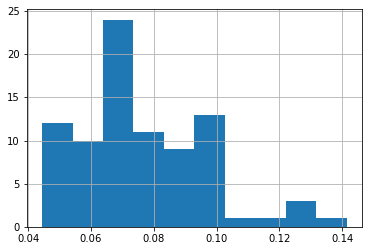

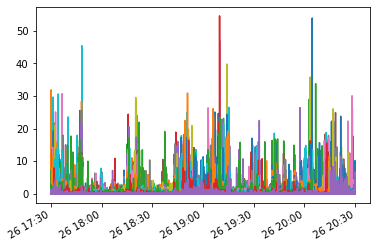

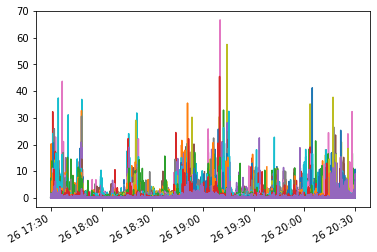

In [35]:
NT = Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),'Event_Duration']

Scale_move = pd.DataFrame()
for i in range(len(NT)):
    Scale_move = pd.concat([Scale_move,aud_df.loc[NT.index[i]+pd.to_timedelta(10,unit='s'):NT.index[i]+pd.to_timedelta(100,unit='s')]],axis=0)

Scale_move.median().hist()
matched_median = Scale_move.median().median()
meds = Scale_move.median()

alt_aud_df = aud_df.copy()

for c in alt_aud_df.columns:
    alt_aud_df[c] = matched_median*aud_df[c]/meds[c]

alt_aud_df.plot(legend = False)
plt.show()
aud_df.plot(legend = False)
plt.show()

In [36]:
aud_df = alt_aud_df.copy()

[Timestamp('2021-10-26 17:36:35'), Timestamp('2021-10-26 20:16:49')]


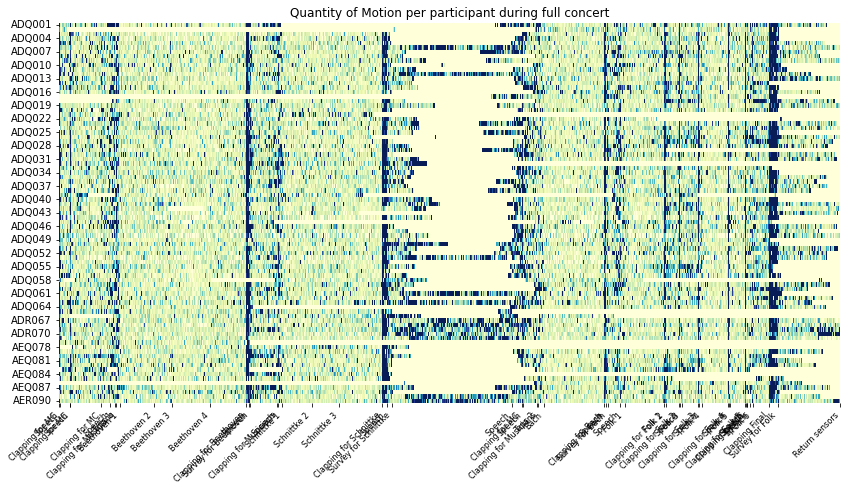

In [43]:
seg_start = concert_times.iloc[0,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[-1,:].name
print([seg_start,seg_end])


seg_times = Main_concert_times

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [14,7])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
plt.xticks(new_xticks,seg_times.Event, rotation='45',fontsize=8, ha='right')
# ax1.set_xticks(new_xticks)
# #ax1.set_xticklabels(seg_times['Event'])
# ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during full concert')
plt.savefig('./Plots/qom_n_full.png',dpi = 300)
plt.show()


## Beethoven

In [38]:
musics = 'Beethoven'
#seg_times = concert_times[concert_times['Event'].str.contains('Beethoven')]
seg_times = concert_times.iloc[50:68].copy()
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times

Time_s  Time_ms         Event         Event_Type  \
Datetime                                                                 
2021-10-26 17:48:46    40.36    40360  Clapping Off    Audience Action   
2021-10-26 17:48:57    50.76    50760         Quiet    Audience Action   
2021-10-26 17:49:03    57.40    57400   Beethoven 1  Music Performance   
2021-10-26 17:55:44   457.84   457840         Quiet    Audience Action   
2021-10-26 17:56:02   476.08   476080   Beethoven 2  Music Performance   
2021-10-26 17:59:19   672.98   672980         Quiet    Audience Action   
2021-10-26 17:59:47   701.18   701180   Beethoven 3  Music Performance   
2021-10-26 18:07:20  1154.28  1154280         Quiet    Audience Action   
2021-10-26 18:07:36  1170.16  1170160   Beethoven 4  Music Performance   
2021-10-26 18:14:55  1608.92  1608920         Quiet    Audience Action   
2021-10-26 18:14:55  1609.36  1609360      Murmures    Audience Action   
2021-10-26 18:14:56  1610.36  1610360      Clapping    Audience Action   
2021-10-26 18:15:28  1642.00  1642000        Danish             Speech   
2021-10-26 18:15:38  1651.88  1651880  Clapping Off    Audience Action   
2021-10-26 18:15:38  1652.00  1652000      Laughter    Audience Action   
2021-10-26 18:15:48  1662.00  1662000        Survey       Instructions   
2021-10-26 18:16:14  1688.40  1688400        Survey       Instructions   
2021-10-26 18:21:19  1992.94  1992940        Danish             Speech   

                     Time_Stream  sequence  
Datetime                                    
2021-10-26 17:48:46      1677.60        50  
2021-10-26 17:48:57      1688.00        51  
2021-10-26 17:49:03      1694.64        52  
2021-10-26 17:55:44      2095.08        53  
2021-10-26 17:56:02      2113.32        54  
2021-10-26 17:59:19      2310.22        55  
2021-10-26 17:59:47      2338.42        56  
2021-10-26 18:07:20      2791.52        57  
2021-10-26 18:07:36      2807.40        58  
2021-10-26 18:14:55      3246.16        59  
2021-10-26 18:14:55      3246.60        60  
2021-10-26 18:14:56      3247.60        61  
2021-10-26 18:15:28      3279.24        62  
2021-10-26 18:15:38      3289.12        63  
2021-10-26 18:15:38      3289.24        64  
2021-10-26 18:15:48      3299.24        65  
2021-10-26 18:16:14      3325.64        66  
2021-10-26 18:21:19      3630.18        67

In [79]:
cmoments = score_times[score_times['Music'].str.contains('Beethoven')]

In [87]:
concert_times.iloc[50,:]['Time_s']

40.36

[Timestamp('2021-10-26 17:48:46'), Timestamp('2021-10-26 18:21:26')]


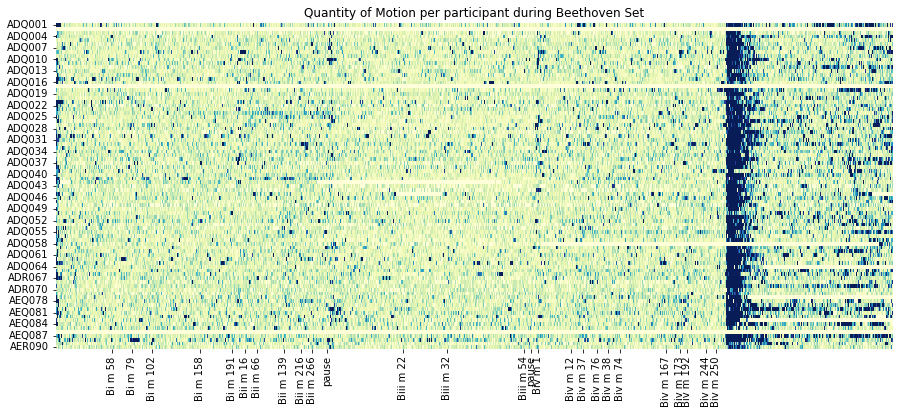

In [88]:
# now evaluate Beethove
seg_start = concert_times.iloc[50,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[68,:].name
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

#new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
new_xticks = len(seg_df)*(cmoments['Time_s'] - concert_times.iloc[50,:]['Time_s'])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax1.set_xticks(new_xticks)
#ax1.set_xticklabels(seg_times['Event'])
ax1.set_xticklabels(cmoments['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
#plt.savefig('./Plots/qom_n_'+musics+'.png',dpi = 300)
plt.show()


In [40]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

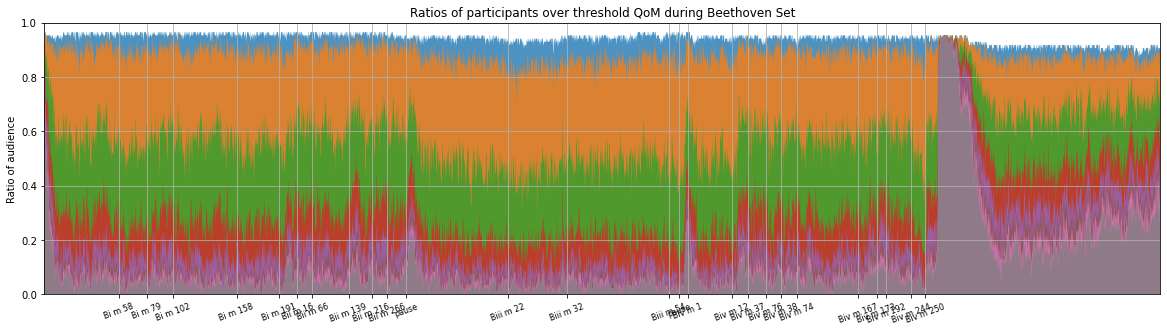

In [91]:
fig,ax = plt.subplots(1,1,figsize=[20,5] )
thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)
    
    
# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
new_xticks = cmoments['Time_s'] - concert_times.iloc[50,:]['Time_s']
plt.xticks(new_xticks,cmoments.Event, rotation='20',fontsize=8)

plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.savefig('./Plots/ubound_n_'+musics+'.png',dpi = 300)
plt.show()

In [48]:
str(np.round(th,1))

'0.3'

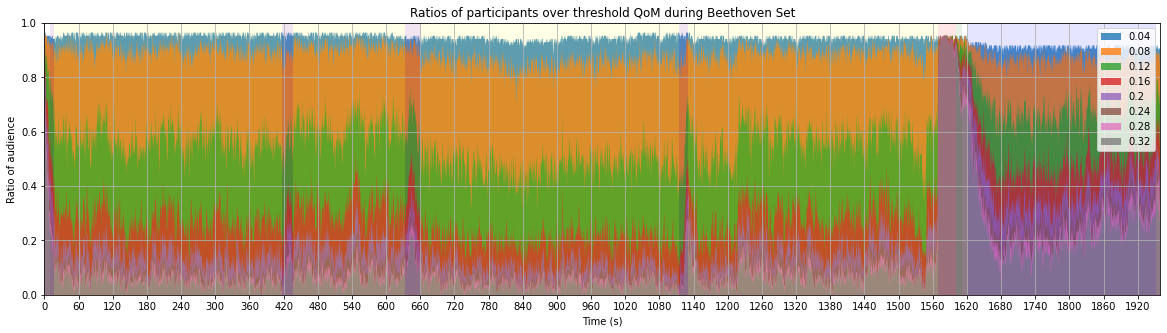

In [92]:
fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
hds = []
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    ha = ax.fill_between(df.index,0,df.Total,alpha = 0.8,label = str(np.round(th,2)))
    hds.append(ha)
    #df.plot(y = 'Total',ax=ax,label=str(th))
#     x = df.index
#     y1 = 0
#     y2 = df.Total
#     ax.fill_between(x,y1,y2,alpha = 0.8,label = str(th))
ax.legend(handles = hds)
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'] - seg_times.iloc[0,0]

yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith('Beethoven'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound_n_'+musics+'.png',dpi = 300)
plt.show()

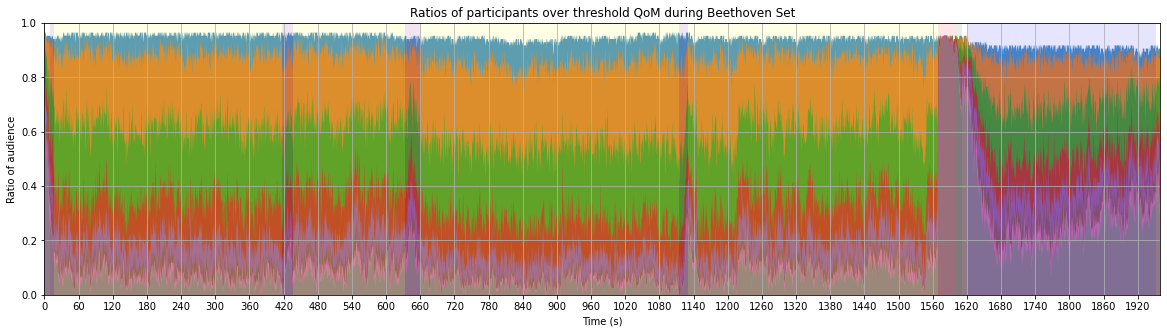

In [62]:
fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)

seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'] - seg_times.iloc[0,0]

yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith('Beethoven'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound__'+musics+'.png',dpi = 300)
plt.show()

In [34]:
x

Float64Index([   0.5,    1.0,    1.5,    2.0,    2.5,    3.0,    3.5,    4.0,
                 4.5,    5.0,
              ...
              1955.0, 1955.5, 1956.0, 1956.5, 1957.0, 1957.5, 1958.0, 1958.5,
              1959.0, 1959.5],
             dtype='float64', name='Time', length=3919)

## Schnittke

In [93]:
cmoments = score_times[score_times['Music'].str.contains('Schnittke')]

[Timestamp('2021-10-26 18:21:42'), Timestamp('2021-10-26 18:46:50')]


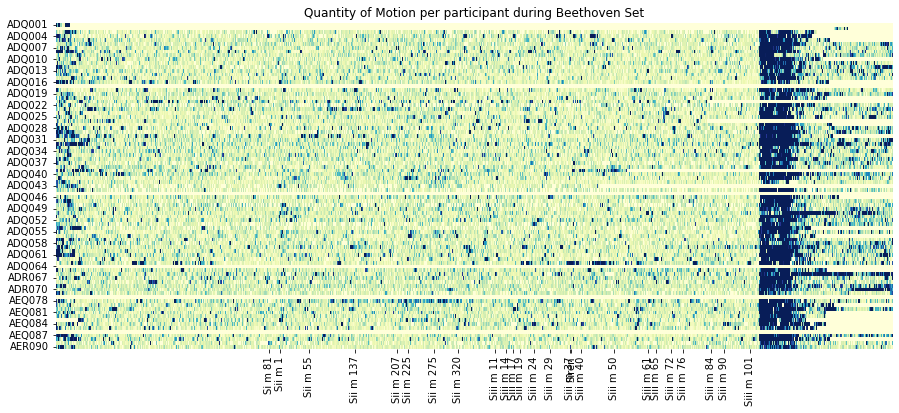

In [94]:
# now evaluate Shnittke
# concert_times.iloc[70:90]
seg_start = concert_times.iloc[70,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[89,:].name
seg_times = Main_concert_times[Main_concert_times['Event'].str.contains('Schnitt')]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(cmoments['Time_s'] - concert_times.iloc[70,:]['Time_s'])/(seg_end.timestamp()-seg_start.timestamp())
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(cmoments['Event'])

# new_xticks = len(seg_df)*(seg_times['Time_s'] - concert_times.iloc[70,:].Time_s)/(seg_end.timestamp()-seg_start.timestamp())
# # plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# ax1.set_xticks(new_xticks)
# ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()


In [95]:
musics = 'Schnittke'
seg_times = concert_times.iloc[70:90].copy()
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'].values - seg_times.iloc[0,0]

#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times

Time_s  Time_ms          Event         Event_Type  \
Datetime                                                                  
2021-10-26 18:21:42     0.00  2016120   Clapping Off    Audience Action   
2021-10-26 18:22:17    34.38  2050500          Quiet    Audience Action   
2021-10-26 18:22:20    38.36  2054480    Schnittke 1  Music Performance   
2021-10-26 18:28:14   392.36  2408480          Quiet    Audience Action   
2021-10-26 18:28:25   402.64  2418760    Schnittke 2  Music Performance   
2021-10-26 18:33:55   733.04  2749160          Quiet    Audience Action   
2021-10-26 18:34:01   739.16  2755280    Schnittke 3  Music Performance   
2021-10-26 18:37:11   929.32  2945440  Passing Siren          Intrusion   
2021-10-26 18:37:14   931.96  2948080       Murmures    Audience Action   
2021-10-26 18:42:35  1253.24  3269360          Quiet    Audience Action   
2021-10-26 18:42:48  1266.24  3282360       Clapping    Audience Action   
2021-10-26 18:43:47  1325.00  3341120       Murmures    Audience Action   
2021-10-26 18:43:49  1326.86  3342980   Clapping Off    Audience Action   
2021-10-26 18:43:51  1328.64  3344760         Danish             Speech   
2021-10-26 18:44:01  1338.84  3354960         Survey       Instructions   
2021-10-26 18:44:18  1356.18  3372300       App Stop       Instructions   
2021-10-26 18:44:39  1376.76  3392880        English             Speech   
2021-10-26 18:44:42  1380.36  3396480       App Stop       Instructions   
2021-10-26 18:44:48  1386.08  3402200         Survey       Instructions   
2021-10-26 18:46:50  1508.34  3524460        Clapper    Synchronisation   

                     Time_Stream  sequence  
Datetime                                    
2021-10-26 18:21:42      3653.36        70  
2021-10-26 18:22:17      3687.74        71  
2021-10-26 18:22:20      3691.72        72  
2021-10-26 18:28:14      4045.72        73  
2021-10-26 18:28:25      4056.00        74  
2021-10-26 18:33:55      4386.40        75  
2021-10-26 18:34:01      4392.52        76  
2021-10-26 18:37:11      4582.68        77  
2021-10-26 18:37:14      4585.32        78  
2021-10-26 18:42:35      4906.60        79  
2021-10-26 18:42:48      4919.60        80  
2021-10-26 18:43:47      4978.36        81  
2021-10-26 18:43:49      4980.22        82  
2021-10-26 18:43:51      4982.00        83  
2021-10-26 18:44:01      4992.20        84  
2021-10-26 18:44:18      5009.54        85  
2021-10-26 18:44:39      5030.12        86  
2021-10-26 18:44:42      5033.72        87  
2021-10-26 18:44:48      5039.44        88  
2021-10-26 18:46:50      5161.70        89

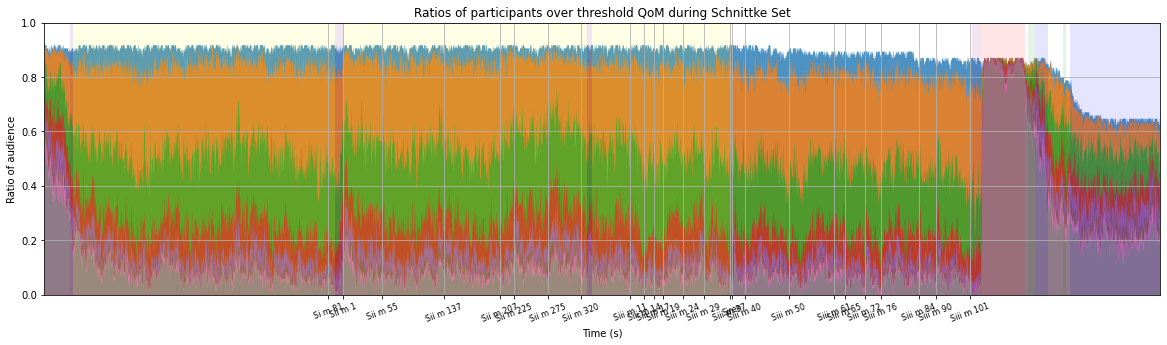

In [97]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)


yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith(musics):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))

# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
new_xticks = cmoments['Time_s'] - concert_times.iloc[70,:]['Time_s']
plt.xticks(new_xticks,cmoments.Event, rotation='20',fontsize=8)
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')


new_xticks = len(seg_df)*(cmoments['Time_s'] - concert_times.iloc[70,:]['Time_s'])/(seg_end.timestamp()-seg_start.timestamp())
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(cmoments['Event'])

plt.savefig('./Plots/ubound_n_'+musics+'.png',dpi = 300)
plt.show()

## Bach

In [98]:
cmoments = score_times[score_times['Music'].str.contains('Bach')]

[Timestamp('2021-10-26 19:15:39'), Timestamp('2021-10-26 19:30:48')]


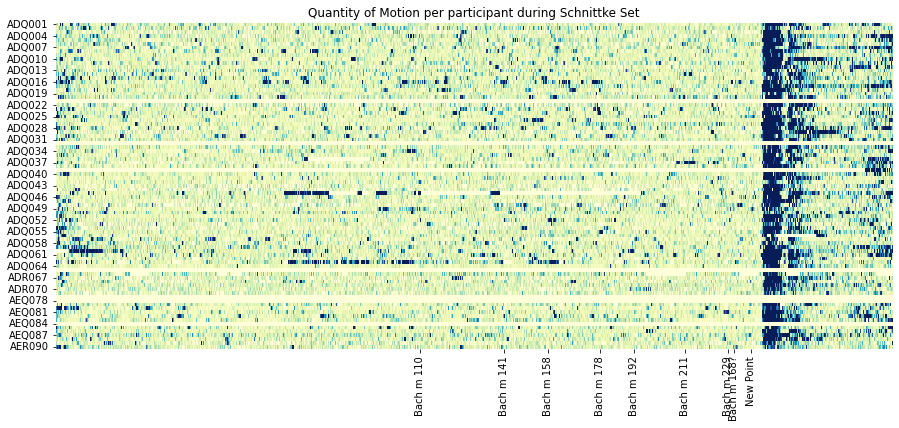

In [99]:

seg_start = concert_times.iloc[122,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[131,:].name
#seg_times = Main_concert_times[Main_concert_times['Event'].str.contains('Schnitt')]
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")
cmoments = score_times[score_times['Music'].str.contains('Bach')]
new_xticks = len(seg_df)*(cmoments['Time_s'] - concert_times.iloc[122,:]['Time_s'])/(seg_end.timestamp()-seg_start.timestamp())
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(cmoments['Event'])
# new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# ax1.set_xticks(new_xticks)
# ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()

In [101]:
musics = 'Bach'
seg_times = concert_times.iloc[122:131].copy()
#seg_times = concert_times[concert_times['Event'].str.contains('Bach')]
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'].values - seg_times.iloc[0,0]

seg_times

Time_s  Time_ms         Event         Event_Type  \
Datetime                                                                
2021-10-26 19:15:39    0.00  5253240      Laughter    Audience Action   
2021-10-26 19:15:46    6.96  5260200         Quiet    Audience Action   
2021-10-26 19:16:00   21.12  5274360          Bach  Music Performance   
2021-10-26 19:28:18  758.56  6011800         Quiet    Audience Action   
2021-10-26 19:28:25  766.20  6019440      Clapping    Audience Action   
2021-10-26 19:28:47  787.84  6041080        Danish             Speech   
2021-10-26 19:28:48  788.54  6041780  Clapping Off    Audience Action   
2021-10-26 19:28:55  796.08  6049320      Laughter    Audience Action   
2021-10-26 19:29:07  808.10  6061340        Survey       Instructions   

                     Time_Stream  sequence  
Datetime                                    
2021-10-26 19:15:39      6890.48       122  
2021-10-26 19:15:46      6897.44       123  
2021-10-26 19:16:00      6911.60       124  
2021-10-26 19:28:18      7649.04       125  
2021-10-26 19:28:25      7656.68       126  
2021-10-26 19:28:47      7678.32       127  
2021-10-26 19:28:48      7679.02       128  
2021-10-26 19:28:55      7686.56       129  
2021-10-26 19:29:07      7698.58       130

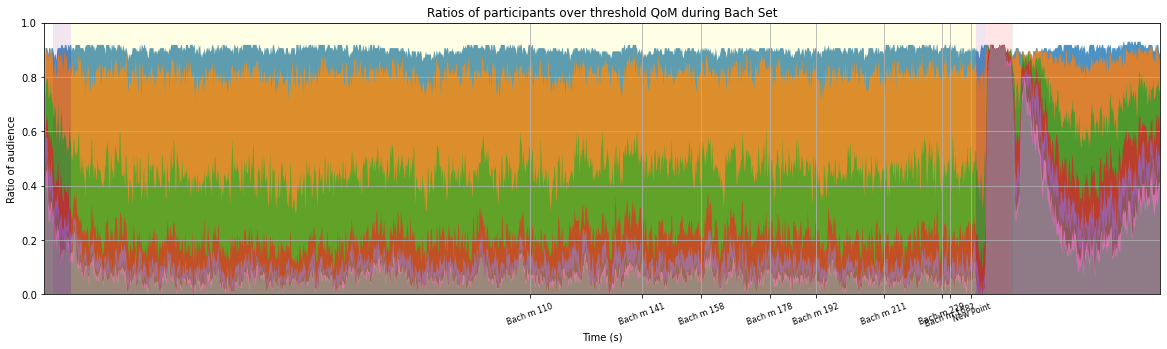

In [102]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

fig,ax = plt.subplots(1,1,figsize=[20,5] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)


yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith(musics):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
new_xticks = cmoments['Time_s'] - concert_times.iloc[122,:]['Time_s']
plt.xticks(new_xticks,cmoments.Event, rotation='20',fontsize=8)
plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound_n_'+musics+'.png',dpi = 300)
plt.show()

## Folk

[Timestamp('2021-10-26 19:32:14'), Timestamp('2021-10-26 20:03:58')]


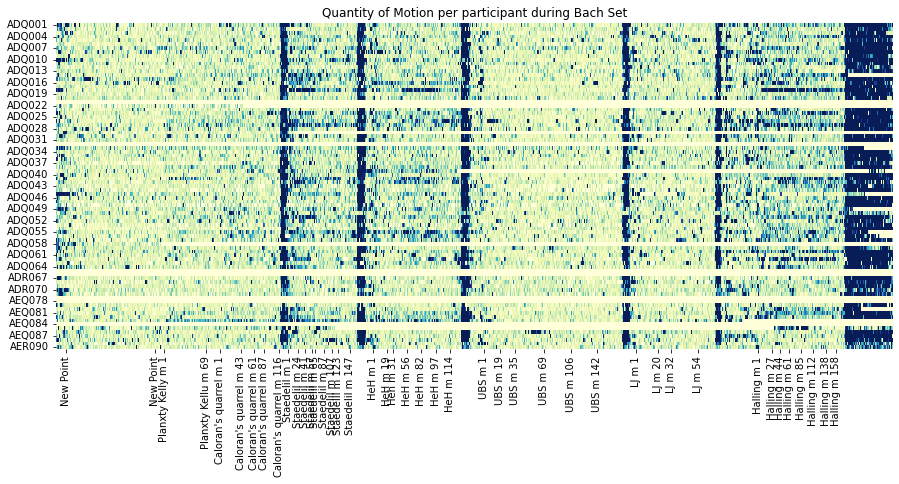

In [103]:

seg_start = concert_times.iloc[134,:].name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = concert_times.iloc[177,:].name
seg_times = concert_times.iloc[134:177].copy()
print([seg_start,seg_end])

seg_df = aud_df.loc[seg_start:seg_end]
#seg_df = seg_df.loc[:,seg_df.sum()>0]
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

cmoments = score_times[score_times['Music'].str.contains('Folk')]
new_xticks = len(seg_df)*(cmoments['Time_s'] - concert_times.iloc[134,:]['Time_s'])/(seg_end.timestamp()-seg_start.timestamp())
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(cmoments['Event'])
# new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# ax1.set_xticks(new_xticks)
# ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set')
plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()

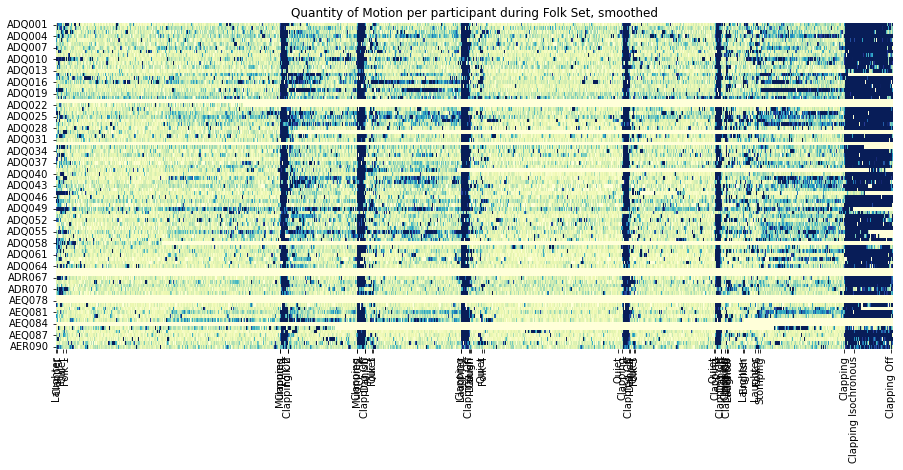

In [126]:
fig, (ax1) = plt.subplots(1, 1,figsize = [15,6])
chart = sns.heatmap(data=Data.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")

new_xticks = len(seg_df)*(seg_times['Time_s'] - seg_times['Time_s'][0])/(seg_end.timestamp()-seg_start.timestamp())
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
ax1.set_xticks(new_xticks)
ax1.set_xticklabels(seg_times['Event'])
plt.title('Quantity of Motion per participant during ' + musics + ' Set, smoothed')
#plt.savefig('./Plots/qom_'+musics+'.png',dpi = 300)
plt.show()

In [104]:
musics = 'Folk'
seg_times = concert_times.iloc[134:177].copy()
seg_times.loc[:,'Time_s'] = seg_times.loc[:,'Time_s'].values - seg_times.iloc[0,0]

#seg_times = concert_times[concert_times['Event'].str.contains('Folk')]
seg_times

Time_s  Time_ms                 Event  \
Datetime                                                      
2021-10-26 19:32:14     0.00  6248280              Laughter   
2021-10-26 19:32:18     3.64  6251920               Clapper   
2021-10-26 19:32:31    16.52  6264800                 Quiet   
2021-10-26 19:32:37    23.00  6271280                Folk 1   
2021-10-26 19:40:44   509.52  6757800              Murmures   
2021-10-26 19:40:45   510.68  6758960              Clapping   
2021-10-26 19:41:02   528.02  6776300          Clapping Off   
2021-10-26 19:41:02   528.20  6776480                Folk 2   
2021-10-26 19:43:39   684.60  6932880              Murmures   
2021-10-26 19:43:39   684.96  6933240              Clapping   
2021-10-26 19:43:59   704.52  6952800          Clapping Off   
2021-10-26 19:43:59   704.56  6952840                Danish   
2021-10-26 19:44:15   720.50  6968780                 Quiet   
2021-10-26 19:44:17   722.52  6970800                Folk 3   
2021-10-26 19:47:36   921.56  7169840              Laughter   
2021-10-26 19:47:36   921.84  7170120              Clapping   
2021-10-26 19:47:55   940.94  7189220          Clapping Off   
2021-10-26 19:47:56   941.68  7189960                Danish   
2021-10-26 19:47:58   943.76  7192040                 Cough   
2021-10-26 19:48:23   968.76  7217040                 Quiet   
2021-10-26 19:48:29   974.48  7222760                Folk 4   
2021-10-26 19:53:34  1280.14  7528420                 Quiet   
2021-10-26 19:53:43  1288.94  7537220              Clapping   
2021-10-26 19:53:59  1304.84  7553120          Clapping Off   
2021-10-26 19:54:00  1305.50  7553780                Danish   
2021-10-26 19:54:09  1314.52  7562800                 Quiet   
2021-10-26 19:54:13  1318.62  7566900                Folk 5   
2021-10-26 19:57:11  1496.52  7744800                 Quiet   
2021-10-26 19:57:14  1499.96  7748240              Clapping   
2021-10-26 19:57:28  1513.60  7761880          Clapping Off   
2021-10-26 19:57:29  1514.52  7762800                Danish   
2021-10-26 19:57:38  1523.60  7771880              Clapping   
2021-10-26 19:57:41  1527.08  7775360                Danish   
2021-10-26 19:57:42  1527.92  7776200          Clapping Off   
2021-10-26 19:57:44  1529.52  7777800              Laughter   
2021-10-26 19:58:17  1562.76  7811040              Laughter   
2021-10-26 19:58:21  1566.84  7815120               English   
2021-10-26 19:58:46  1591.72  7840000              Laughter   
2021-10-26 19:58:51  1596.82  7845100                Folk 6   
2021-10-26 19:58:57  1602.68  7850960              Stomping   
2021-10-26 20:02:08  1793.96  8042240              Clapping   
2021-10-26 20:02:30  1815.76  8064040  Clapping Isochronous   
2021-10-26 20:03:55  1901.00  8149280          Clapping Off   

                            Event_Type  Time_Stream  sequence  
Datetime                                                       
2021-10-26 19:32:14    Audience Action      7885.52       134  
2021-10-26 19:32:18    Synchronisation      7889.16       135  
2021-10-26 19:32:31    Audience Action      7902.04       136  
2021-10-26 19:32:37  Music Performance      7908.52       137  
2021-10-26 19:40:44    Audience Action      8395.04       138  
2021-10-26 19:40:45    Audience Action      8396.20       139  
2021-10-26 19:41:02    Audience Action      8413.54       140  
2021-10-26 19:41:02  Music Performance      8413.72       141  
2021-10-26 19:43:39    Audience Action      8570.12       142  
2021-10-26 19:43:39    Audience Action      8570.48       143  
2021-10-26 19:43:59    Audience Action      8590.04       144  
2021-10-26 19:43:59             Speech      8590.08       145  
2021-10-26 19:44:15    Audience Action      8606.02       146  
2021-10-26 19:44:17  Music Performance      8608.04       147  
2021-10-26 19:47:36    Audience Action      8807.08       148  
2021-10-26 19:47:36    Audience Action      8807.36       149  
2021-10-26 19:47:55    Audience Ac

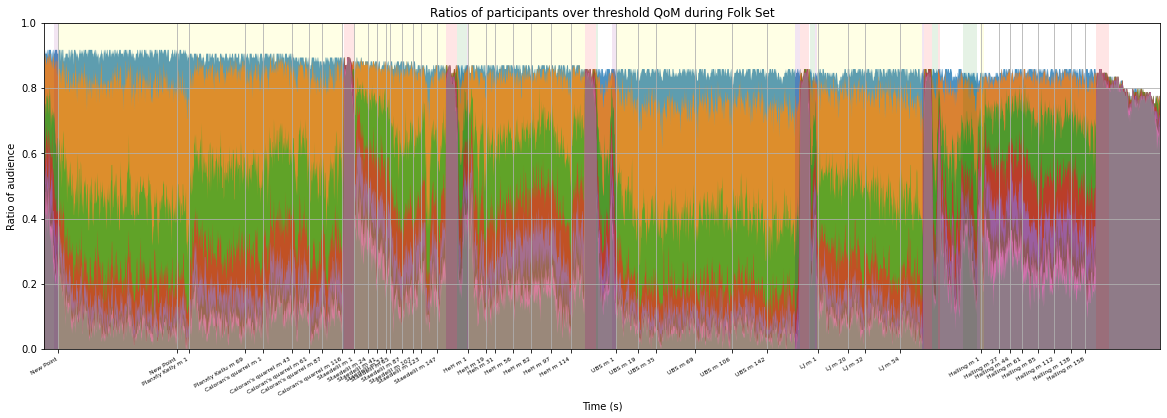

In [107]:
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

fig,ax = plt.subplots(1,1,figsize=[20,6] )

thresh = np.arange(0.04,0.32,0.04)
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,1,0.5,th,'UBound')
    df_threshed[str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8)


yrange = [0,2.0]
for i in range(len(seg_times)-1):
    r= seg_times.iloc[i,:]
    ei = seg_times.Time_s[i]
    ej = seg_times.Time_s[i+1]
    if r['Event'].endswith('Clapping'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='red', alpha=0.1)
    if r['Event'].startswith(musics):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='yellow', alpha=0.1)
    if r['Event_Type'].endswith('Speech'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='green', alpha=0.1)
    if r['Event'].startswith('Survey'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='blue', alpha=0.1)
    if r['Event'].startswith('Quiet'):
        ax.axvspan(ei, ej,yrange[0],yrange[1], facecolor='purple', alpha=0.1)

# new_xticks = seg_times['Time_s'] - seg_times['Time_s'][0]
#plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
# plt.xticks(np.arange(seg_times.Time_s[0],seg_times.Time_s[-1],60))
new_xticks = cmoments['Time_s'] - concert_times.iloc[134,:]['Time_s']
plt.xticks(new_xticks,cmoments.Event, rotation='30',fontsize=6,ha='right')

plt.xlim([x[0]-1,x[-1]])
plt.ylim([0,1])
plt.ylabel('Ratio of audience')
plt.grid() 
plt.title('Ratios of participants over threshold QoM during ' + musics + ' Set')
plt.xlabel('Time (s)')

plt.savefig('./Plots/ubound_n_'+musics+'.png',dpi = 300)
plt.show()

In [114]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / (fs/2)
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# must filter first
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

for c in Data.columns:
    Data.loc[:,c] = butter_lowpass_filter(Data.loc[:,c], 2, 10, 2)

In [117]:
# must filter first
Data = seg_df.copy()
Data.index = np.arange(0,len(seg_df))/10

for c in Data.columns:
    Data.loc[:,c] = butter_lowpass_filter(Data.loc[:,c], 2, 10, 2)

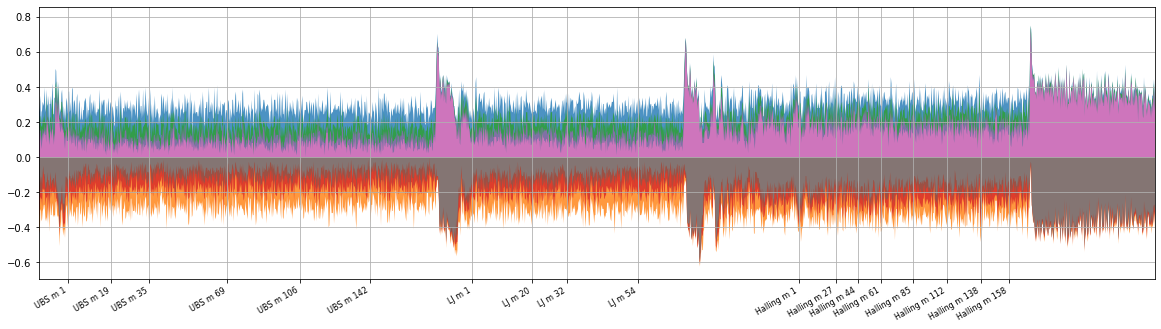

In [116]:
thresh = np.arange(0.02,0.10,0.02)
wind = 1
hop = 0.5
fig,ax = plt.subplots(1,1,figsize=[20,5] )
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    df_threshed['Inc_'+str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label='Inc')

    df = aa.activityCount(Data,wind,hop,th,'Dec')
    df_threshed['Dec_'+str(th)]=-df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = -df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')
# new_xticks = (seg_times['Time_s'] - seg_times['Time_s'][0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
new_xticks = cmoments['Time_s'] - concert_times.iloc[134,:]['Time_s']
plt.xticks(new_xticks,cmoments.Event, rotation='30',fontsize=8,ha='right')

plt.xlim([950,1900])
plt.grid()
plt.savefig('./Plots/IncDec_n_'+musics+'2.png',dpi = 300)

plt.show()
#df_threshed.plot()

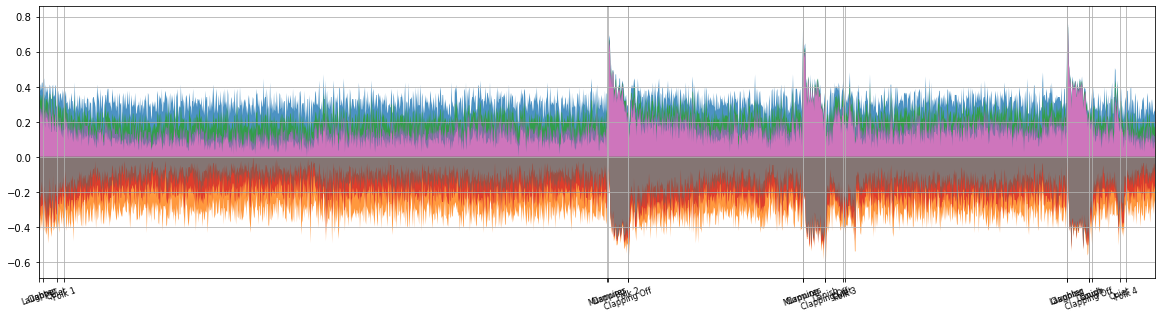

In [108]:
thresh = np.arange(0.02,0.10,0.02)
wind = 1
hop = 0.5
fig,ax = plt.subplots(1,1,figsize=[20,5] )
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    df_threshed['Inc_'+str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label='Inc')

    df = aa.activityCount(Data,wind,hop,th,'Dec')
    df_threshed['Dec_'+str(th)]=-df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = -df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')
new_xticks = (seg_times['Time_s'] - seg_times['Time_s'][0])
plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xlim([0,1000])
plt.grid()
plt.show()
#df_threshed.plot()

In [178]:
thresh = np.arange(0.02,0.05,0.02)
wind = 1
hop = 0.5

alph = 0.01
ShuffleRange = 10
Iter = 1000

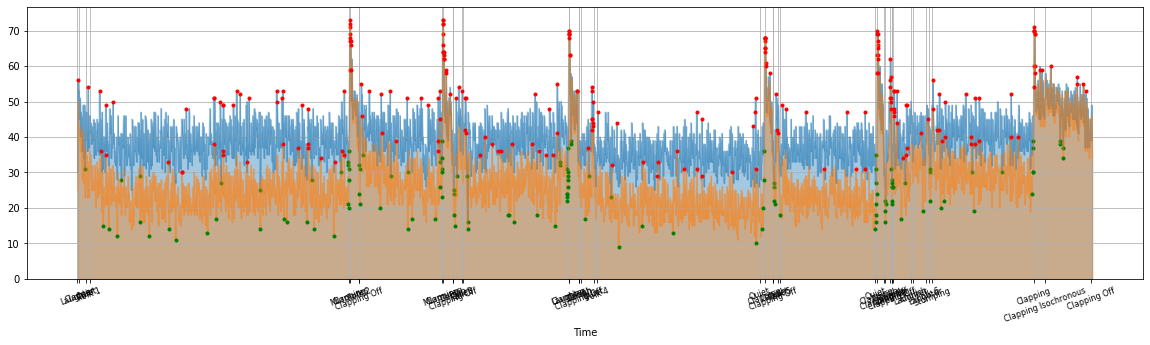

In [179]:
fig,ax = plt.subplots(1,1,figsize=[20,5])
for th in thresh:
#th = 0.04
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    Actions = df.drop(columns=['Total'])
    Actions= Actions.fillna(0)
    Actions.columns = np.arange(0,len(Actions.columns))
    stest = aa.localActivityTest(Actions,FrameSize,ShuffleRange,Iter,alph)

    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=ax,alpha = 0.4)
    if stest['CoordScore'] >=-np.log10(alph):
        HA=B.loc[B['Surprise']<0,'Activity-levels']
        HA.plot(style='r.',ax=ax)
        HA=B.loc[B['Surprise']>0,'Activity-levels']
        HA.plot(style='g.',ax=ax)
    else:
        B['Activity-levels'].plot(style='y.',ax=ax)

new_xticks = (seg_times['Time_s'] - seg_times['Time_s'][0])
plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
#plt.xlim([0,1000])
plt.grid()
plt.show()   

C:\Users\finnu\AppData\Local\Temp\ipykernel_2712\2783282923.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B.loc[:,'Activity-levels'] = -B['Activity-levels']
C:\Users\finnu\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1437: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)


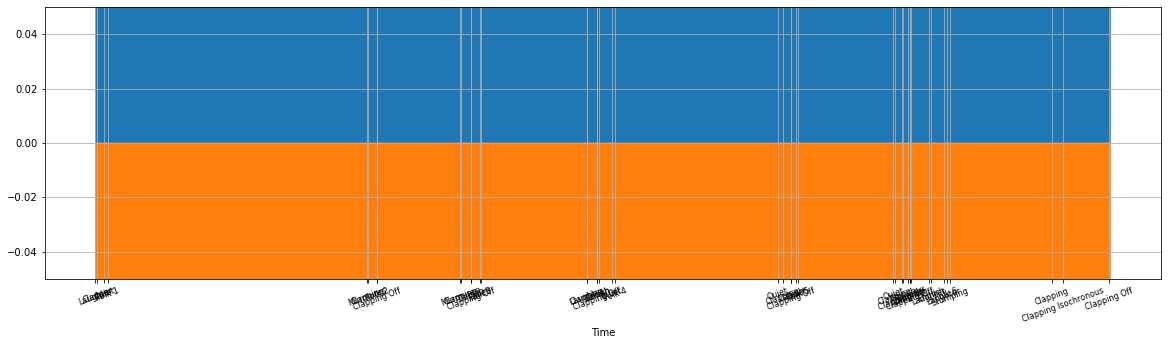

In [176]:
thresh = np.arange(0.02,0.05,0.02)
wind = 1
hop = 0.5

alpha = 0.01
ShuffleRange = 10
Iter = 1000

fig,ax = plt.subplots(1,1,figsize=[20,5])
df_threshed = pd.DataFrame()

for th in thresh:
    df = aa.activityCount(Data,wind,hop,th,'Inc')
#     df_threshed['Inc_'+str(th)]=df['Total']
#     #df.plot(y = 'Total',ax=ax,label=str(th))
#     x = df.index
#     y1 = 0
#     y2 = df.Total
#     ax.fill_between(x,y1,y2,alpha = 0.8)
    # evaluate local activity
    Actions = df.drop(columns=['Total'])
    Actions= Actions.fillna(0)
    Actions.columns = np.arange(0,len(Actions.columns))
    stest = aa.localActivityTest(Actions,FrameSize,ShuffleRange,Iter,alpha)
    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    C = stest['CoordScore']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=ax,label ='Inc_'+str(th))
    if stest['CoordScore'] >=-np.log10(alpha):
        HA=B.loc[B['Surprise']<0,'Activity-levels']
        HA.plot(style='r.',ax=ax)
        HA=B.loc[B['Surprise']>0,'Activity-levels']
        HA.plot(style='g.',ax=ax)
    else:
        B['Activity-levels'].plot(style='y.',ax=ax)

    df = aa.activityCount(Data,wind,hop,th,'Dec')
#     df_threshed['Dec_'+str(th)]=-df['Total']
#     #df.plot(y = 'Total',ax=ax,label=str(th))
#     x = df.index
#     y1 = 0
#     y2 = -df.Total
#     ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')
        # evaluate local activity
    Actions = df.drop(columns=['Total'])
    Actions= Actions.fillna(0)
    Actions.columns = np.arange(0,len(Actions.columns))
    stest = aa.localActivityTest(Actions,FrameSize,ShuffleRange,Iter,alpha)
    A = stest['MeasuredResults']
    A.loc[:,'Activity-levels'] = -A['Activity-levels']
    B = stest['ActivityPeaks']
    B.loc[:,'Activity-levels'] = -B['Activity-levels']
    C = stest['CoordScore']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=ax,label ='Dec_'+str(th))
    if C >=-np.log10(alpha):
        HA=B.loc[B['Surprise']<0,'Activity-levels']
        HA.plot(style='r.',ax=ax)
        HA=B.loc[B['Surprise']>0,'Activity-levels']
        HA.plot(style='g.',ax=ax)
    else:
        B['Activity-levels'].plot(style='y.',ax=ax)
        
new_xticks = (seg_times['Time_s'] - seg_times['Time_s'][0])
plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
#plt.xlim([0,1000])
plt.grid()
plt.show()
#df_threshed.plot()

In [175]:
x

Float64Index([   0.5,    1.0,    1.5,    2.0,    2.5,    3.0,    3.5,    4.0,
                 4.5,    5.0,
              ...
              1899.0, 1899.5, 1900.0, 1900.5, 1901.0, 1901.5, 1902.0, 1902.5,
              1903.0, 1903.5],
             dtype='float64', name='Time', length=3807)

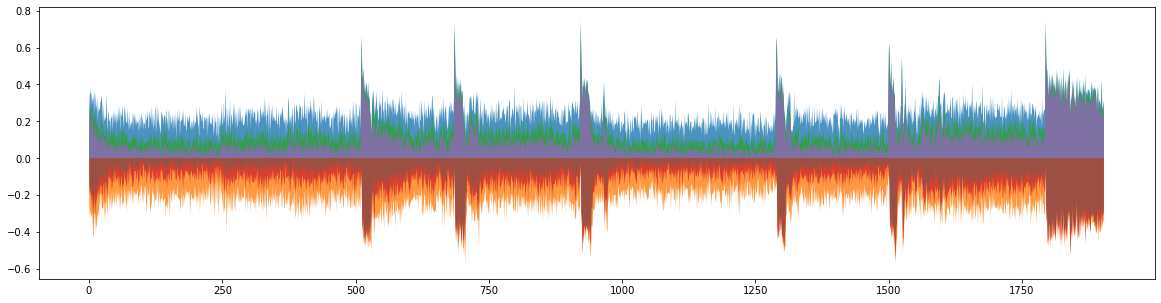

In [110]:
thresh = np.arange(0.04,0.16,0.04)

fig,ax = plt.subplots(1,1,figsize=[20,5] )
df_threshed = pd.DataFrame()
for th in thresh:
    wind = 1
    hop = 1
    Data = seg_df.copy()
    Data.index = np.arange(0,len(seg_df))/10

    df = aa.activityCount(Data,wind,hop,th,'Inc')
    df_threshed['Inc_'+str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label='Inc')


    df = aa.activityCount(Data,wind,hop,th,'Dec')
    df_threshed['Dec_'+str(th)]=-df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = -df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')

plt.show()
#df_threshed.plot()

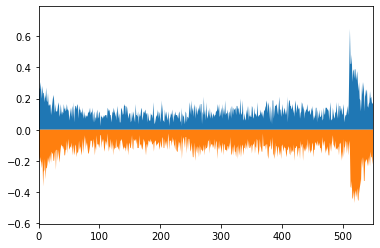

In [107]:
plt.fill_between(df_threshed.index,df_threshed.Inc,0)
plt.fill_between(df_threshed.index,df_threshed.Dec,0)
plt.xlim([0,550])
plt.show()

# evaluate activity coordination per movement
This will run through the movement measured per movement of music and evaluate whether there is sufficient coordination in movement increases (or decreases) to consider the participants motions coordinated. Unlike the section above, which included applause and stretched over a huge interval of time, this will focus on pieces


In [185]:
Musics = Main_concert_times.loc[Main_concert_times['Event_Type'].str.startswith('Music'),:]
Musics

Time_s  Time_ms        Event Event_Type  Time_Stream  \
Datetime                                                                     
2021-10-26 17:49:03    57.40    57400  Beethoven 1      Music      1694.64   
2021-10-26 17:56:02   476.08   476080  Beethoven 2      Music      2113.32   
2021-10-26 17:59:47   701.18   701180  Beethoven 3      Music      2338.42   
2021-10-26 18:07:36  1170.16  1170160  Beethoven 4      Music      2807.40   
2021-10-26 18:22:20  2054.48  2054480  Schnittke 1      Music      3691.72   
2021-10-26 18:28:25  2418.76  2418760  Schnittke 2      Music      4056.00   
2021-10-26 18:34:01  2755.28  2755280  Schnittke 3      Music      4392.52   
2021-10-26 19:16:00  5274.36  5274360         Bach      Music      6911.60   
2021-10-26 19:32:37  6271.28  6271280       Folk 1      Music      7908.52   
2021-10-26 19:41:02  6776.48  6776480       Folk 2      Music      8413.72   
2021-10-26 19:44:17  6970.80  6970800       Folk 3      Music      8608.04   
2021-10-26 19:48:29  7222.76  7222760       Folk 4      Music      8860.00   
2021-10-26 19:54:13  7566.90  7566900       Folk 5      Music      9204.14   
2021-10-26 19:58:51  7845.10  7845100       Folk 6      Music      9482.34   

                     Event_Duration  sequence  
Datetime                                       
2021-10-26 17:49:03          418.68         8  
2021-10-26 17:56:02          225.10         9  
2021-10-26 17:59:47          468.98        10  
2021-10-26 18:07:36          440.20        11  
2021-10-26 18:22:20          364.28        17  
2021-10-26 18:28:25          336.52        18  
2021-10-26 18:34:01          527.08        19  
2021-10-26 19:16:00          745.08        28  
2021-10-26 19:32:37          487.68        33  
2021-10-26 19:41:02          156.76        35  
2021-10-26 19:44:17          199.32        38  
2021-10-26 19:48:29          314.46        41  
2021-10-26 19:54:13          181.34        44  
2021-10-26 19:58:51          197.14        50

[Timestamp('2021-10-26 19:32:37'), Timestamp('2021-10-26 19:40:44.680000')]


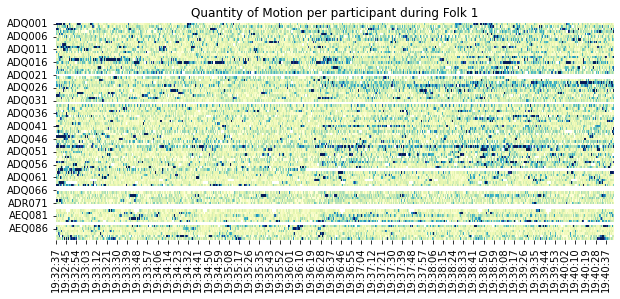

In [209]:
i = 8
Mus = Musics.iloc[i,:]

seg_start = Mus.name #concert_times[concert_times['events'].str.contains('Beethoven 1')].index
seg_end = Mus.name + pd.to_timedelta(Mus['Event_Duration'],unit='S')
print([seg_start,seg_end])
seg_df = aud_df.loc[seg_start:seg_end].copy()

fig, (ax1) = plt.subplots(1, 1,figsize = [10,4])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")
ax1.set_xticklabels(seg_df.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))

plt.title('Quantity of Motion per participant during ' + Mus['Event'])
plt.show()
# # must filter first
# Data = seg_df.copy()
# Data.index = np.arange(0,len(seg_df))/10

# for c in Data.columns:
#     Data.loc[:,c] = butter_lowpass_filter(Data.loc[:,c], 2, 10, 2)

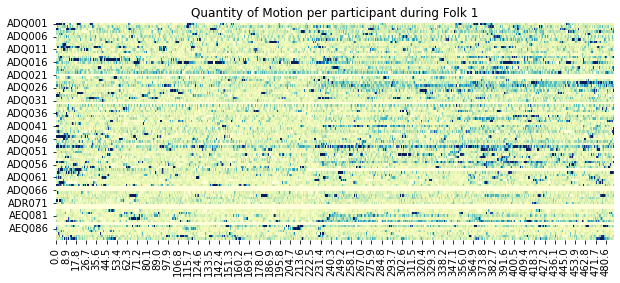

In [210]:
# # must filter first
Data = seg_df.copy()
Data = Data.fillna(0)
Data.index = np.arange(0,len(seg_df))/10

for c in Data.columns:
    Data.loc[:,c] = butter_lowpass_filter(Data.loc[:,c], 2, 10, 2)
    
    
fig, (ax1) = plt.subplots(1, 1,figsize = [10,4])
chart = sns.heatmap(data=Data.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu")
#ax1.set_xticklabels(Data.iloc[ax1.get_xticks()].index.strftime("%H:%M:%S"))

plt.title('Quantity of Motion per participant during ' + Mus['Event'])
plt.show()

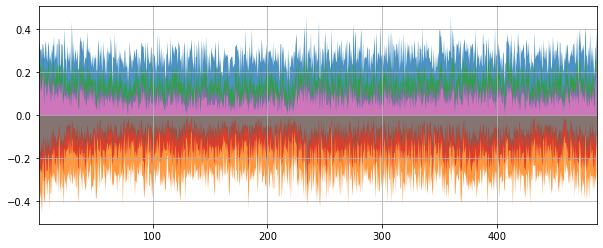

In [211]:
thresh = np.arange(0.02,0.10,0.02)
wind = 1
hop = 0.5
fig,ax = plt.subplots(1,1,figsize=[10,4] )
df_threshed = pd.DataFrame()
for th in thresh:
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    df_threshed['Inc_'+str(th)]=df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label='Inc')

    df = aa.activityCount(Data,wind,hop,th,'Dec')
    df_threshed['Dec_'+str(th)]=-df['Total']
    #df.plot(y = 'Total',ax=ax,label=str(th))
    x = df.index
    y1 = 0
    y2 = -df.Total
    ax.fill_between(x,y1,y2,alpha = 0.8,label = 'Dec')
# new_xticks = (seg_times['Time_s'] - seg_times['Time_s'][0])
# plt.xticks(new_xticks,seg_times.Event, rotation='20',fontsize=8)
plt.xlim([x[0],x[-1]])
plt.grid()
plt.show()

C:\Users\finnu\AppData\Local\Temp\ipykernel_2712\3930781367.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  B.loc[:,'Inv_Activity-levels'] = -B.loc[:,'Activity-levels'].copy()
C:\Users\finnu\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1437: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(None, 0)
C:\Users\finnu\AppData\Local\Temp\ipykernel_2712\3930781367.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

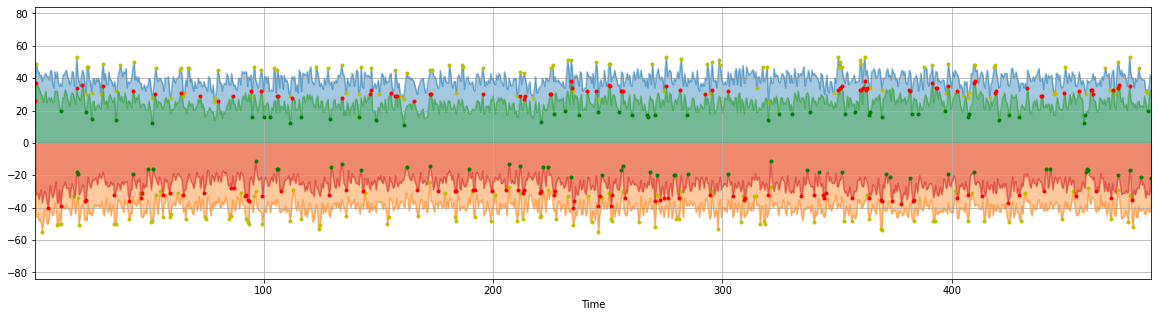

In [212]:
thresh = np.arange(0.02,0.05,0.02)
wind = 1
hop = 0.5

alph = 0.05
ShuffleRange = 10
Iter = 5000

fig,ax = plt.subplots(1,1,figsize=[20,5])
for th in thresh:
#th = 0.04
    df = aa.activityCount(Data,wind,hop,th,'Inc')
    Actions = df.drop(columns=['Total'])
    Actions= Actions.fillna(0)
    Actions.columns = np.arange(0,len(Actions.columns))
    stest = aa.localActivityTest(Actions,FrameSize,ShuffleRange,Iter,alph)

    A = stest['MeasuredResults']
    B = stest['ActivityPeaks']
    # plot the activity levels with local activity peaks
    A['Activity-levels'].plot.area(ax=ax,alpha = 0.4)
    if stest['CoordScore'] >=-np.log10(alph):
        HA=B.loc[B['Surprise']<0,'Activity-levels']
        HA.plot(style='r.',ax=ax)
        HA=B.loc[B['Surprise']>0,'Activity-levels']
        HA.plot(style='g.',ax=ax)
    else:
        B['Activity-levels'].plot(style='y.',ax=ax)
        
    df = aa.activityCount(Data,wind,hop,th,'Dec')
    Actions = df.drop(columns=['Total'])
    Actions= Actions.fillna(0)
    Actions.columns = np.arange(0,len(Actions.columns))
    stest = aa.localActivityTest(Actions,FrameSize,ShuffleRange,Iter,alph)

    A = stest['MeasuredResults']
    A.loc[:,'Inv_Activity-levels'] = -A.loc[:,'Activity-levels'].copy()
    B = stest['ActivityPeaks']
    B.loc[:,'Inv_Activity-levels'] = -B.loc[:,'Activity-levels'].copy()
    # plot the activity levels with local activity peaks
    A['Inv_Activity-levels'].plot.area(ax=ax,alpha = 0.4)
    if stest['CoordScore'] >=-np.log10(alph):
        HA=B.loc[B['Surprise']<0,'Inv_Activity-levels']
        HA.plot(style='r.',ax=ax)
        HA=B.loc[B['Surprise']>0,'Inv_Activity-levels']
        HA.plot(style='g.',ax=ax)
    else:
        B['Inv_Activity-levels'].plot(style='y.',ax=ax)
x = df.index
plt.xlim([x[0],x[-1]])
plt.ylim([-84,84])
plt.grid()
plt.show() 

# Amount of motion

Evaluate total or average motion per peice of MUSIC in Hall AND Virtual audiences

In [13]:
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A','B']),:] # in person hall participant or remote
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
#alignedParts

In [14]:
tic = time.time()
# load those motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct)
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()

aud_df.index = dt_ct
print(time.time()-tic)

98.69740128517151


In [15]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]

[seg_start,seg_end ]

[57.4, 8042.24]

In [16]:
aud_df.index = (ts_ct/1000).round(1)
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

In [17]:
Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mov_df = pd.DataFrame(columns = seg_df.columns,index=Event_ranges.keys())
seg_df = aud_df.copy()
#seg_df = seg_df.fillna(0)
for ev in Event_ranges:
    print(ev)
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mov_df.loc[ev,:] = seg_df.loc[seg_start:seg_end,:].copy().mean(skipna=True)

mov_df


Beethoven
Schnittke
Bach
Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6


ADQ001    ADQ002    ADQ003    ADQ004    ADQ005    ADQ006  \
Beethoven   0.06931       NaN  0.094418  0.101832  0.073396  0.108571   
Schnittke       NaN       NaN   0.09243  0.143005  0.082105  0.117091   
Bach       0.056344  0.135227  0.095909  0.124162  0.076236  0.103214   
Folk 1     0.092763  0.108706  0.113461   0.11108  0.091294  0.094409   
Folk 2     0.107179  0.112969  0.134227   0.16998  0.132951  0.109864   
Folk 3     0.093821  0.110445  0.120349  0.200489   0.09407  0.122745   
Folk 4     0.058239  0.104601  0.105789  0.106932  0.100064  0.093399   
Folk 5     0.076783  0.113608  0.109129    0.2069  0.112852  0.092305   
Folk 6     0.131336  0.122249   0.17015  0.278143  0.105464  0.129512   

             ADQ007    ADQ008    ADQ009    ADQ010  ...    BEQ113    BEQ114  \
Beethoven  0.079436  0.086551  0.078944  0.132908  ...  0.050849  0.209203   
Schnittke  0.071236  0.084851  0.083309  0.106298  ...       NaN  0.324695   
Bach       0.072805  0.075117  0.063814  0.103792  ...       NaN       NaN   
Folk 1     0.108131  0.100647   0.06888  0.128617  ...  0.129728       NaN   
Folk 2     0.169403    0.1276  0.103629  0.278259  ...  0.155217       NaN   
Folk 3     0.134144  0.181669  0.076284  0.200711  ...  0.177113       NaN   
Folk 4     0.107378  0.071827  0.066724   0.08968  ...   0.14281       NaN   
Folk 5     0.087781   0.09075  0.077657  0.171621  ...  0.098097       NaN   
Folk 6     0.164427  0.115135  0.096362  0.254176  ...  0.081031       NaN   

             BEQ115    BEQ116    BEQ117    BEQ118    BEQ119    BnQ131  \
Beethoven  0.106643   0.16461  0.342741  0.182283       NaN  0.084129   
Schnittke  0.160089  0.174854  0.288413  0.168656       NaN       NaN   
Bach       0.161927       NaN       NaN       NaN  0.043821  0.080859   
Folk 1     0.314134  1.029549       NaN       NaN       NaN  0.119573   
Folk 2     0.226191       NaN       NaN       NaN       NaN  0.077603   
Folk 3          NaN       NaN       NaN       NaN       NaN  0.091614   
Folk 4          NaN       NaN       NaN       NaN       NaN  0.084257   
Folk 5          NaN       NaN       NaN       NaN       NaN  0.090013   
Folk 6          NaN       NaN       NaN       NaN       NaN  0.111303   

             BnQ132    BnQ133  
Beethoven  0.271856       NaN  
Schnittke  0.142884       NaN  
Bach       0.044488  0.064076  
Folk 1     0.069146  0.124333  
Folk 2     0.118621  0.105172  
Folk 3     0.142352  0.086665  
Folk 4     0.025852  0.052904  
Folk 5      0.06018  0.077249  
Folk 6     0.022379  0.270537  

[9 rows x 115 columns]

In [18]:
Cond = ['Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Hall','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual','Virtual'] # hall for 85 and virtual for 30
seg_df.columns.values
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}

#Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
mm_df = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])
for ev in Event_ranges:
    print(ev)
    if ev.startswith('Bee'):
        sec = 'First Half'
    else:
        if ev.startswith('Sch'):
            sec = 'First Half'
        else:
            sec = 'Second Half'
    mdf = pd.DataFrame(columns=['Participant','Condition','Music','mQoM'])
    mdf['Participant']= seg_df.columns.values
    mdf['Condition'] = Cond
    mdf['Music'] = ev
    mdf['Halfs'] = sec
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mdf.loc[:,'mQoM'] = aud_df.loc[seg_start:seg_end,:].copy().mean(skipna=True).values
    mm_df = pd.concat([mm_df,mdf])

#mm_df

Beethoven 1
Beethoven 2
Beethoven 3
Beethoven 4
Schnittke 1
Schnittke 2
Schnittke 3
Bach
Folk 1
Folk 2
Folk 3
Folk 4
Folk 5
Folk 6


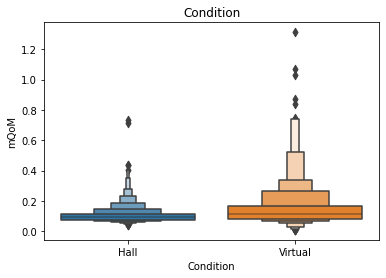

      Source  ddof1  ddof2          F         p-unc       np2
0  Condition      1   1415  82.284863  3.833997e-19  0.054956


In [19]:
sns.boxenplot(x = 'Condition',y = 'mQoM', data = mm_df)
plt.title('Condition')
#plt.savefig('plots/PairCorr_allEvents_Proximity.png',dpi = 400)
plt.show()
aov = pg.anova(dv='mQoM',between = 'Condition', data=mm_df)
print(aov)

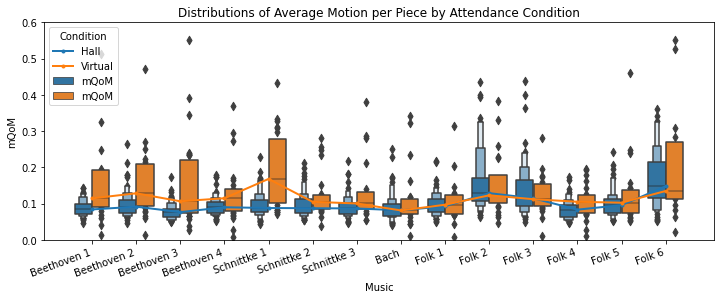

Source        SS  DF1  DF2        MS          F         p-unc  \
0    Condition  0.165318    1   76  0.165318   6.793529  1.100507e-02   
1        Music  0.983115   13  988  0.075624  20.867935  4.697339e-44   
2  Interaction  0.171217   13  988  0.013171   3.634310  1.216332e-05   

        np2       eps  
0  0.082054       NaN  
1  0.215427  0.220543  
2  0.045637       NaN

In [20]:
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))

sns.boxenplot(x = 'Music',y = 'mQoM', hue = 'Condition',data = mm_df, ax = ax1)
groupby = mm_df.loc[mm_df['Condition']=='Hall',:].groupby('Music', axis=0)
A = groupby.median()
A.loc[Event_ranges.keys(),:].plot(style = '.-',linewidth = 2,ax = ax1)
groupby = mm_df.loc[mm_df['Condition']=='Virtual',:].groupby('Music', axis=0)
A = groupby.median()
A.loc[Event_ranges.keys(),:].plot(style = '.-',linewidth = 2,ax = ax1)
plt.xticks(rotation='20',ha = 'right',fontsize=10)
plt.title('Distributions of Average Motion per Piece by Attendance Condition')
plt.ylim([0,0.6])
plt.savefig('plots/Musics_mQoM_Hall_Virtual.png',dpi = 400)
plt.show()
pg.mixed_anova(dv='mQoM',within = 'Music',between = 'Condition',subject='Participant', data=mm_df)
